# Lab: Convolutional NNs for CIFAR 10


------------------------------------------------------
*Alex Guerrero (Lab instructor): alexjorguer@tsc.uc3m.es*

*Alejandro Lancho: alancho@ing.uc3m.es*

*Original material from Pablo M. Olmos*
------------------------------------------------------


In this lab, we will use a data set of (small) natural images known as  [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). Our goal is to present i) how CNN layers are used in Pytorch, and ii) evaluate the performance of a simple CNN over this dataset.

Note: a big part of the following material is a personal wrap-up of [Facebook's Deep Learning Course in Udacity](https://www.udacity.com/course/deep-learning-pytorch--ud188). So all credit goes for them!!

**IMPORTANT NOTE:** In this notebook I show you how to speed up NN training using Graphical Processing Units (GPUs). To make sure you use a Google Colaboratory server equipped with a GPU, go to `Edit` --> `Notebook Settings` --> Select GPU in `Hardware Accelerator`

In [30]:
from IPython.display import Image
from IPython.core.display import HTML 

Image(url= "https://pytorch.org/tutorials/_images/cifar10.png", width=400, height=300)

In [31]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
import time

## Part I. Download CIFAR10 with `torchvision`

The code below will download the CIFAR10 dataset, then create training and test datasets for us. It is mostly the same code we used to download MNIST in the previous part of the Lab.

In [32]:
import torch
from torchvision import datasets, transforms, utils

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [33]:
traindata = iter(trainloader)

images, labels = next(traindata)

print(images[1].shape)

torch.Size([3, 32, 32])


In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize to pot
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

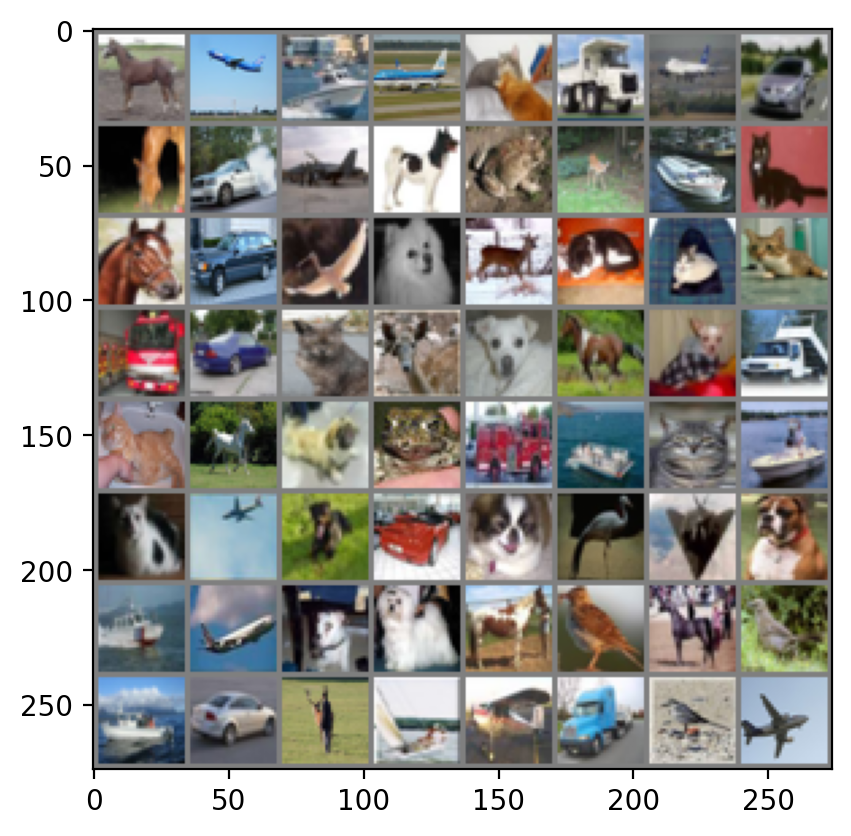

In [35]:
imshow(utils.make_grid(images))


> **Exercise:** Create a validation set using the 20% of train images

In [36]:
# YOUR CODE HERE
import copy

validloader = copy.deepcopy(trainloader)

total_train_size = len(trainloader.dataset.data)

train_limit = int(0.8 * total_train_size)

trainloader.dataset.data = trainloader.dataset.data[:train_limit]
trainloader.dataset.targets = trainloader.dataset.targets[:train_limit]

validloader.dataset.data = validloader.dataset.data[train_limit:]
validloader.dataset.targets = validloader.dataset.targets[train_limit:]

## Part II. Implement Lenet 5

Our first goal is to implement the LeNet 5 CNN network, first published in November 1998. See the original paper [here](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

In [37]:
Image(url= "https://ichi.pro/assets/images/max/724/0*H9_eGAtkQXJXtkoK")

In the CNN network above we have 2 convolutional layers with the following properties:

- ReLU activation functions are used as non-linear functions
- Maxpooling with $2\times 2$ kernels is used to reduce the spatial dimension in both layers.
- $5\times 5$ convolutional filters are used. Stride is 1.
- After the second convolutional layer, three dense layers are stacked. 

Note that CIFAR-10 images are composed by **3 input color maps**, each of dimension $32\times32$.

> **Exercise:** Complete the following code that defines the above CNN. But first read the [`torch.nn.Conv2d`](https://pytorch.org/docs/stable/nn.html) documentation.

In [38]:
class Lenet5(nn.Module):
    def __init__(self,dimx,nlabels): #Nlabels will be 10 in our case
        super().__init__()

        # convolutional layer (sees 28x28x1 image tensor)
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, 
                               kernel_size=5, stride=1, padding=0)
        
        # convolutional layer (sees 12x12x16 tensor)
        self.conv2 = nn.Conv2d(6, 16, 5, padding=0)
        
        # Max pool layer
        self.pool = nn.MaxPool2d(2, 2)


        # Spatial dimension of the Tensor at the output of the 2nd CNN
        self.final_dim = int(((dimx-4)/2-4)/2)
        
        # Linear layers
        self.linear1 = nn.Linear(16 * self.final_dim * self.final_dim, 120)
        
        self.linear2 = nn.Linear(120, 84)
        
        self.linear3 = nn.Linear(84, nlabels)
    
        self.relu = nn.ReLU()
        
        self.logsoftmax = nn.LogSoftmax(dim=1) 
          
    def forward(self, x):
        # Pass the input tensor through the CNN operations
        x = self.conv1(x) #YOUR CODE HERE
        x = self.relu(x) 
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        
        # Flatten the tensor into a vector of appropiate dimension using self.final_dim
        x = x.view(x.size(0), -1)
        
        # Pass the tensor through the Dense Layers
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = self.logsoftmax(x) 
        return x


Now the network is defined, by now you should know how to move forward by your own!!

> **Exercise:** Extend the class to incorporate a training method, to evaluate the both the validation and train losses and to evaluate the classification performance in a set.

In [39]:
#YOUR CODE HERE
class Lenet5_extended(Lenet5):
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.CrossEntropyLoss()
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            running_loss = 0
            self.train()
            
            for images, labels in trainloader:
                self.optim.zero_grad()
                
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                
                loss.backward()
                self.optim.step()
                
            self.loss_during_training.append(running_loss / len(trainloader))
            
            valid_loss = 0
            with torch.no_grad():
                self.eval()

                for images, labels in validloader:
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    valid_loss += loss.item()
                    
            self.valid_loss_during_training.append(valid_loss / len(validloader))
            
            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f} "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f} ")
    
    def evaluate(self, dataloader):
        accuracy = 0
        
        with torch.no_grad():
            self.eval()
            
            for images, labels in dataloader:
                logprobs = self.forward(images)
                _, top_class = logprobs.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        return accuracy / len(dataloader)

> **Exercise:** Train the model for 5 epochs, plot the train/validation loss during training, and compute the train and validation performance. It will take some time!!

Epoch 1/5.. Training loss: 1.688 Validation loss: 1.522 
Epoch 2/5.. Training loss: 1.399 Validation loss: 1.367 
Epoch 3/5.. Training loss: 1.287 Validation loss: 1.269 
Epoch 4/5.. Training loss: 1.203 Validation loss: 1.221 
Epoch 5/5.. Training loss: 1.143 Validation loss: 1.173 


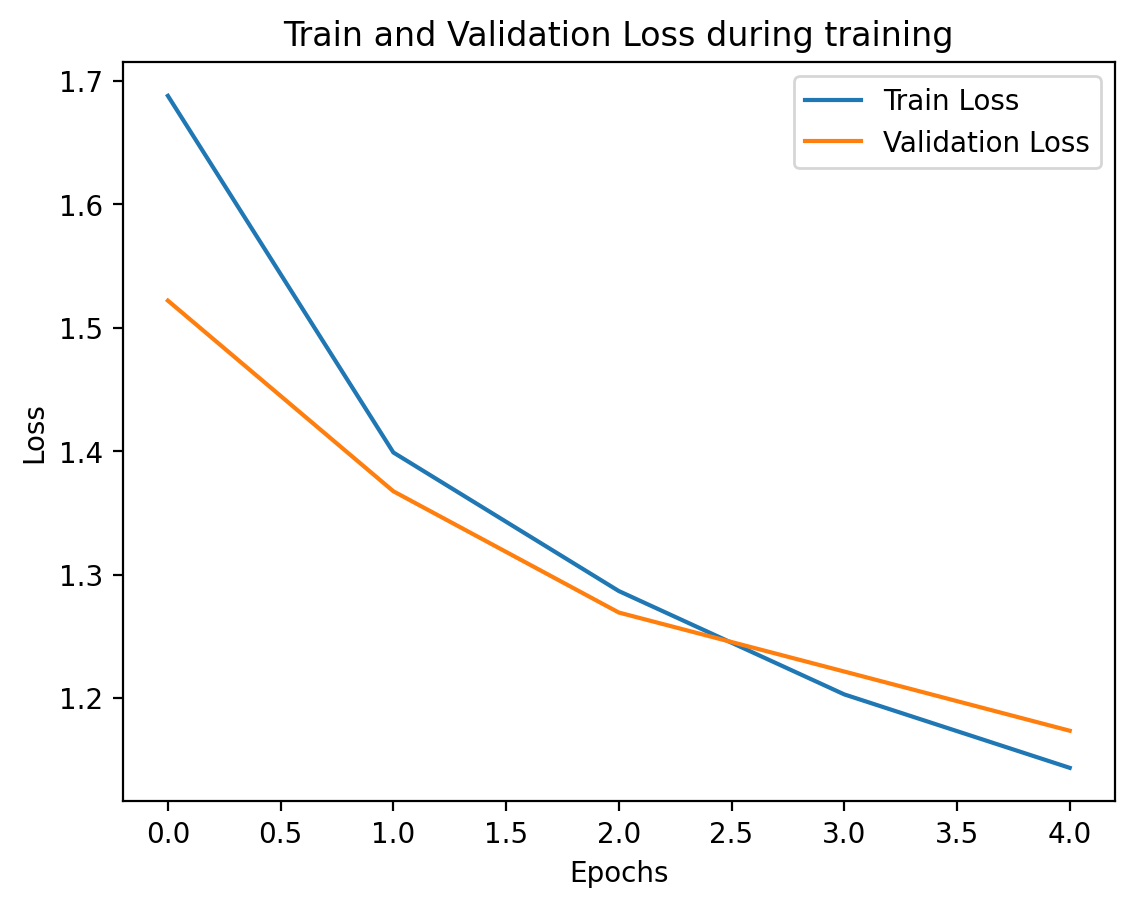

Train Accuracy: 62.47%
Validation Accuracy: 58.56%


In [40]:
my_CNN = Lenet5_extended(dimx=32, nlabels=10, epochs=5, lr=0.001)

my_CNN.trainloop(trainloader, validloader)

plt.plot(my_CNN.loss_during_training, label="Train Loss")
plt.plot(my_CNN.valid_loss_during_training, label="Validation Loss")
plt.title("Train and Validation Loss during training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

train_accuracy = my_CNN.evaluate(trainloader)
val_accuracy = my_CNN.evaluate(validloader)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

## Part III. GPU-based training

As you noticed, training became excessively slow. The newtork is already quite deep and gradient evaluation becomes a heavy operation. 

PyTorch, along with pretty much every other deep learning framework, uses [CUDA](https://developer.nvidia.com/cuda-zone) to efficiently compute the forward and backwards passes on the GPU. In PyTorch, you move your model parameters and other tensors to the GPU memory using `model.to('cuda')`. You can move them back from the GPU with `model.to('cpu')` which you'll commonly do when you need to operate on the network output outside of PyTorch. As a demonstration of the increased speed, I'll compare how long it takes to perform a forward and backward pass with and without a GPU.

You can write device agnostic code which will automatically use CUDA if it's enabled like so:
```python
# at beginning of the script
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

...

# then whenever you get a new Tensor or Module
# this won't copy if they are already on the desired device
input = data.to(device)
model = MyModule(...).to(device)
```

> **Exercise:** Complete the following class, which implements the CNN training and validation using a GPU (if possible). 

**Note: Google Colab Recommended**. When running the notebook in Google Colab, make sure you first to `Edit -- Notebook settings` and **select a GPU as Hardware accelerator.**



In [43]:
class Lenet5_extended_GPU(Lenet5):
    
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001):
        super().__init__(dimx, nlabels)
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), lr=self.lr)
        self.epochs = epochs
        self.criterion = nn.CrossEntropyLoss()
        
        self.loss_during_training = []
        self.valid_loss_during_training = []
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.to(self.device)
        
    def trainloop(self, trainloader, validloader):
        for e in range(int(self.epochs)):
            start_time = time.time()
            running_loss = 0.0
            self.train()
            
            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                self.optim.zero_grad()
                
                out = self.forward(images)
                
                loss = self.criterion(out, labels)
                
                running_loss += loss.item()
                
                loss.backward()
                
                self.optim.step()
            
            self.loss_during_training.append(running_loss / len(trainloader))
            
            self.eval()
            valid_running_loss = 0.0
            
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    
                    out = self.forward(images)
                    
                    loss = self.criterion(out, labels)
                    valid_running_loss += loss.item()
            
            self.valid_loss_during_training.append(valid_running_loss / len(validloader))
            
            print(f"Epoch {e + 1}/{self.epochs}.. "
                  f"Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}.. "
                  f"Time per epoch: {time.time() - start_time:.3f} seconds")
    
    def evaluate(self, dataloader):
        accuracy = 0.0
        self.eval()
        
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                out = self.forward(images)
                
                _, top_class = out.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
        return accuracy / len(dataloader)

In [44]:
my_CNN_GPU = Lenet5_extended_GPU(dimx=32,nlabels=10,epochs=5,lr=1e-3)

my_CNN_GPU.trainloop(trainloader,validloader)

Epoch 1/5.. Training loss: 1.715.. Validation loss: 1.526.. Time per epoch: 31.099 seconds
Epoch 2/5.. Training loss: 1.429.. Validation loss: 1.366.. Time per epoch: 29.940 seconds
Epoch 3/5.. Training loss: 1.289.. Validation loss: 1.294.. Time per epoch: 29.939 seconds
Epoch 4/5.. Training loss: 1.190.. Validation loss: 1.200.. Time per epoch: 30.031 seconds
Epoch 5/5.. Training loss: 1.113.. Validation loss: 1.127.. Time per epoch: 29.879 seconds


In [ ]:
plt.plot(my_CNN_GPU.loss_during_training,label='Training Loss')
plt.plot(my_CNN_GPU.valid_loss_during_training,label='Validation Loss')
plt.legend()

print(my_CNN_GPU.eval_performance(trainloader))
print(my_CNN_GPU.eval_performance(validloader))

With a GPU, you will see that the time per epoch roughly decreases significantly. As we train deeper and much more complex networks, **this difference grows exponentially fast**. Using GPUs is a must for lage-scale deployment.

## Part IV. Regularize the network and compare with a MLP

> **Exercise**: Now that you know how to train the CNN network, your goals are:
> - Check that the CNN is able to overfit
> - Regularize the network with both early stopping and dropout. In my experience, it is more efficient to include the dropout layers in between the final MLP layers, rather than in between convolutional layers. Note that once you include dropout, it wil take more epochs to converge. The more dropout layers, the more epochs typically you have to run. For this exercise, run at least 50 epochs.
> - Check the train/validation/test performance, plot the train and validation losses

In [45]:
#YOUR CODE HERE (Check CNN overfiting)
model = Lenet5_extended(dimx=32, nlabels=10, epochs=20, lr=0.001)

train_subset = torch.utils.data.Subset(trainset, list(range(subset_size)))
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=64, shuffle=True)

model.trainloop(trainloader, validloader)

train_accuracy = model.evaluate(trainloader)
val_accuracy = model.evaluate(validloader)

print(f"Train Accuracy (overfit): {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy (overfit): {val_accuracy * 100:.2f}%")


Epoch 1/20.. Training loss: 2.293 Validation loss: 2.259 
Epoch 2/20.. Training loss: 2.151 Validation loss: 2.081 
Epoch 3/20.. Training loss: 1.993 Validation loss: 2.048 
Epoch 4/20.. Training loss: 1.895 Validation loss: 1.967 
Epoch 5/20.. Training loss: 1.843 Validation loss: 1.940 
Epoch 6/20.. Training loss: 1.756 Validation loss: 1.868 
Epoch 7/20.. Training loss: 1.692 Validation loss: 1.886 
Epoch 8/20.. Training loss: 1.660 Validation loss: 1.813 
Epoch 9/20.. Training loss: 1.601 Validation loss: 1.811 
Epoch 10/20.. Training loss: 1.560 Validation loss: 1.787 
Epoch 11/20.. Training loss: 1.502 Validation loss: 1.812 
Epoch 12/20.. Training loss: 1.480 Validation loss: 1.778 
Epoch 13/20.. Training loss: 1.422 Validation loss: 1.747 
Epoch 14/20.. Training loss: 1.368 Validation loss: 1.793 
Epoch 15/20.. Training loss: 1.335 Validation loss: 1.810 
Epoch 16/20.. Training loss: 1.292 Validation loss: 1.815 
Epoch 17/20.. Training loss: 1.243 Validation loss: 1.813 
Epoch 

In [48]:
#YOUR CODE HERE (Regularize the network)
class Lenet5_with_dropout(Lenet5):
    def __init__(self, dimx, nlabels, epochs=100, lr=0.001, dropout_rate=0.5):
        super().__init__(dimx, nlabels)
        
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.CrossEntropyLoss()
        self.dropout = nn.Dropout(dropout_rate)
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        
        x = x.view(x.size(0), -1)
        
        x = self.dropout(self.relu(self.linear1(x)))
        x = self.dropout(self.relu(self.linear2(x)))
        x = self.logsoftmax(self.linear3(x))
        return x

    def trainloop(self, trainloader, validloader, early_stop_epochs=5):
        early_stop_counter = 0
        best_val_loss = float('inf')
        
        for e in range(int(self.epochs)):
            running_loss = 0
            self.train()

            for images, labels in trainloader:
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()
                out = self.forward(images)
                loss = self.criterion(out, labels)
                running_loss += loss.item()
                loss.backward()
                self.optim.step()

            self.loss_during_training.append(running_loss / len(trainloader))

            valid_running_loss = 0
            self.eval()
            with torch.no_grad():
                for images, labels in validloader:
                    images, labels = images.to(self.device), labels.to(self.device)
                    out = self.forward(images)
                    loss = self.criterion(out, labels)
                    valid_running_loss += loss.item()

            avg_valid_loss = valid_running_loss / len(validloader)
            self.valid_loss_during_training.append(avg_valid_loss)
            
            if avg_valid_loss < best_val_loss:
                best_val_loss = avg_valid_loss
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            
            if early_stop_counter >= early_stop_epochs:
                print(f"Early stopping at epoch {e + 1}")
                break
            
            print(f"Epoch {e + 1}/{self.epochs}.. Training loss: {self.loss_during_training[-1]:.3f}.. "
                  f"Validation loss: {self.valid_loss_during_training[-1]:.3f}")
            
    def evaluate(self, dataloader):
        accuracy = 0.0
        self.eval()  
        
        with torch.no_grad():
            for images, labels in dataloader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                out = self.forward(images)
                
                _, top_class = out.topk(1, dim=1)
                equals = (top_class == labels.view(images.shape[0], 1))
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                
        return accuracy / len(dataloader)


Epoch 1/50.. Training loss: 2.300.. Validation loss: 2.291
Epoch 2/50.. Training loss: 2.277.. Validation loss: 2.256
Epoch 3/50.. Training loss: 2.224.. Validation loss: 2.161
Epoch 4/50.. Training loss: 2.160.. Validation loss: 2.091
Epoch 5/50.. Training loss: 2.095.. Validation loss: 2.038
Epoch 6/50.. Training loss: 2.047.. Validation loss: 2.016
Epoch 7/50.. Training loss: 2.000.. Validation loss: 1.987
Epoch 8/50.. Training loss: 1.971.. Validation loss: 1.964
Epoch 9/50.. Training loss: 1.972.. Validation loss: 1.943
Epoch 10/50.. Training loss: 1.908.. Validation loss: 1.917
Epoch 11/50.. Training loss: 1.883.. Validation loss: 1.888
Epoch 12/50.. Training loss: 1.852.. Validation loss: 1.877
Epoch 13/50.. Training loss: 1.840.. Validation loss: 1.860
Epoch 14/50.. Training loss: 1.817.. Validation loss: 1.832
Epoch 15/50.. Training loss: 1.815.. Validation loss: 1.851
Epoch 16/50.. Training loss: 1.774.. Validation loss: 1.857
Epoch 17/50.. Training loss: 1.761.. Validation l

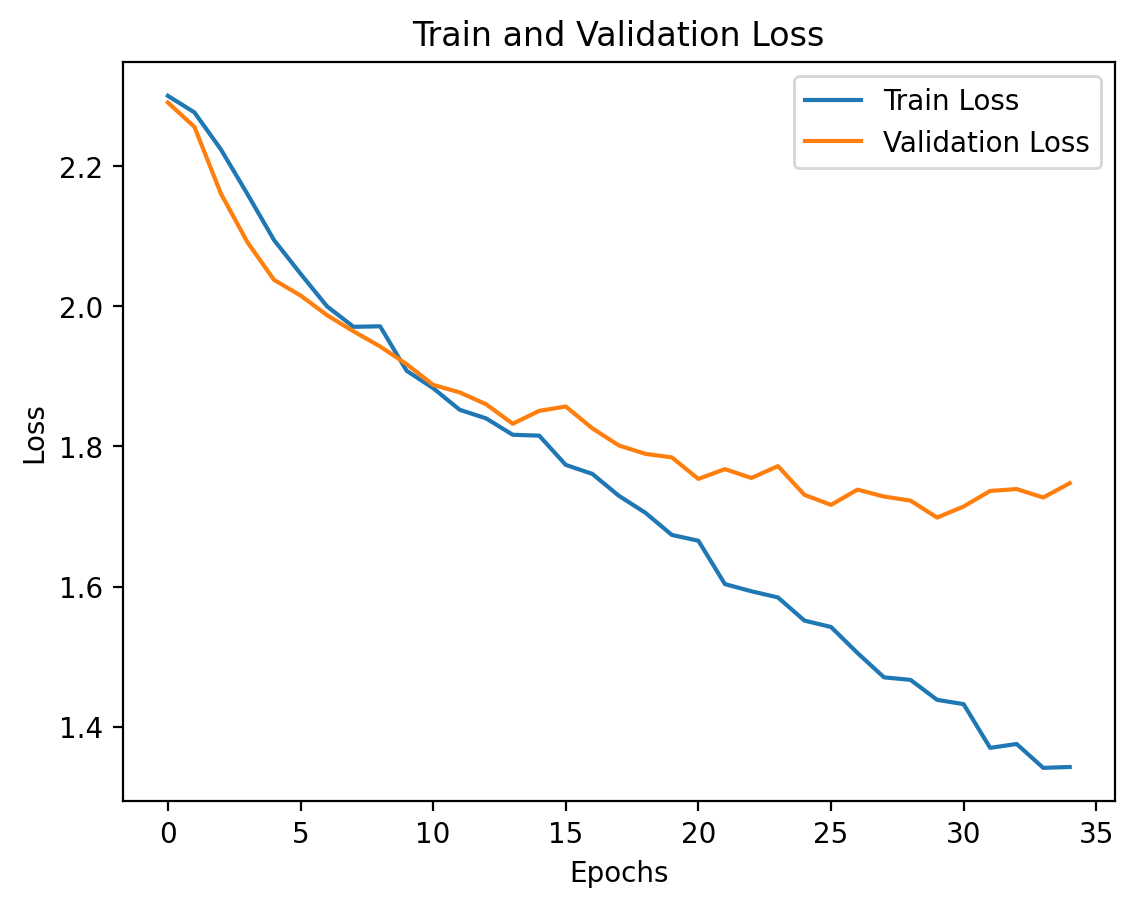

In [49]:
#YOUR CODE HERE
model = Lenet5_with_dropout(dimx=32, nlabels=10, epochs=50, lr=0.001, dropout_rate=0.5)

model.trainloop(trainloader, validloader, early_stop_epochs=5)

train_accuracy = model.evaluate(trainloader)
val_accuracy = model.evaluate(validloader)
test_accuracy = model.evaluate(testloader)

print(f"Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

plt.plot(model.loss_during_training, label='Train Loss')
plt.plot(model.valid_loss_during_training, label='Validation Loss')
plt.title("Train and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Train an MLP to compare the performance (Optional)

Train an MLP with 3-4 layers to compare the performance. Take into account that the input image has three color maps. If you stuck it into a vector, then the input dimension is 3x32x32 = 3072. An alternative is to compute the average between the three. Alternatively, you could use only one color map, or the average between three of them ...

In [ ]:
#YOUR CODE HERE